In [2]:
import pretty_midi as pm
import scipy
import os
import matplotlib.pyplot as plt
import glob
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()


if not os.getcwd().endswith("/music"):
    os.chdir("music")

# infにmidiを読み込む
inf = pm.PrettyMIDI('example.mid')
inf.instruments

#中身の確認
x = inf.instruments[0]
print(len(x.notes))
print(x.is_drum)
print(x.name)
print(x.get_pitch_class_histogram())

x.program

170
False

[30.  0. 10.  2. 22. 32.  6. 20.  0. 28. 20.  0.]


0

Tempo: 155.833489
(128, 72)


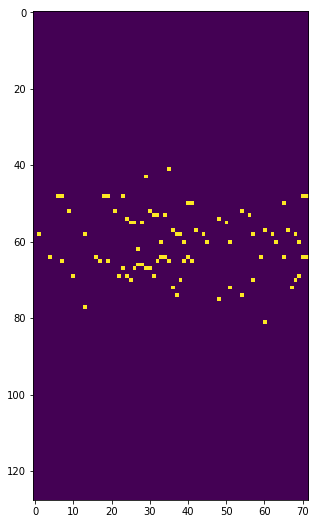

In [3]:
# ドラムを使わない。音符の多い8つのトラック(intrument)に限定
def IsolateMelody(dat):
  interesting = [i for i in dat.instruments if lambda i: len(i.notes)>0 and not i.is_drum]
  interesting = sorted(interesting, reverse=True, key=lambda i: len(i.notes))
  return interesting[0:8]

# 8つのトラックを1つ目に全部入れる。
def MergeInstruments(insts):
  out = insts[0]
  out.name = "merged"
  for inst in insts[1:]:
    out.notes += inst.notes
  return out

inf = pm.PrettyMIDI('example.mid')
out = pm.PrettyMIDI()
out.instruments = [MergeInstruments(IsolateMelody(inf))]
out.write("testout.mid")
print("Tempo: %f" % out.estimate_tempo())
pr = out.get_piano_roll(fs=out.estimate_tempo()/60/2)
#pr = out.get_chroma(times=out.get_beats())
print(pr.shape)

fig = plt.figure(figsize=(14, 9))
ax  = fig.add_subplot(1, 1, 1)
plt.imshow(pr)

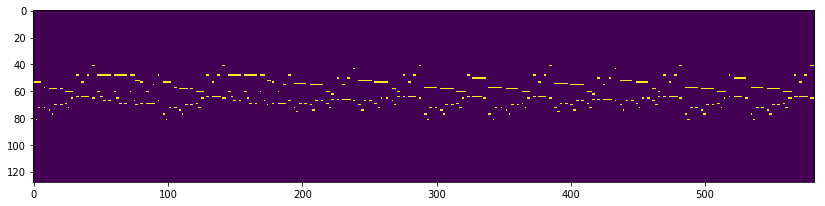

In [4]:
def Datify(file):
  md = pm.PrettyMIDI(file);
  out = pm.PrettyMIDI()
  out.instruments = [MergeInstruments(IsolateMelody(md))]
  dat = {'src': file, 'midi': md, 'simplified': out}
  dat['tempo'] = out.estimate_tempo()
  dat['fs'] = out.estimate_tempo()/60*4
  dat['frames'] = out.get_end_time() / dat['fs']
  dat['pr'] = out.get_piano_roll(dat['fs'])
  return dat

def Sequify(file):
  return Datify(file)['pr'];

def ExpSeq(pr):
  # We need to broadcast the image array such that it has a batch dimension
  # https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb
  return np.expand_dims(pr, axis=0)

def SqSeq(pr):
  return np.squeeze(pr, axis=0)

def Pr(dat):
  return dat['pr']

def PlotPR(pr):
  fig = plt.figure(figsize=(14, 9))
  ax  = fig.add_subplot(1, 1, 1)
  #img = SqSeq(pr)
  img = pr
  plt.imshow(img)

PlotPR(Sequify("example.mid"))

In [5]:
if True:
  corpus = [Datify(file) for file in sorted(glob.glob("liszt/*.mid"))]

In [6]:
print(len(corpus))
print(corpus[0]['pr'].shape)

11
(128, 13400)


In [122]:
# 学習して生成したpiano rollをmidi fileを元に戻す
import pretty_midi
def piano_roll_to_pretty_midi(piano_roll, fs=100.0, program=1):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.abs(np.diff(piano_roll).T)>10) # 要素間の差分をとる

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 20:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = np.clip(velocity, 0, 127)
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

In [123]:
# 前処理と後処理の確認。corp0-in.midがinput、corp0-simp.midが前処理後、corp0-conv.midが
# corp0-simp.midを一度piano rollに変換した後midiファイルに戻したもの。
np.savetxt("corp0.tsv", corpus[0]['pr'], delimiter="\t")
piano_roll_to_pretty_midi(corpus[0]['pr'], corpus[0]['fs']).write("corp0-conv.mid")
print("Wrote: %s @ %s" % (corpus[0]['src'], corpus[0]['fs']))
corpus[0]['midi'].write("corp0-in.mid")
corpus[0]['simplified'].write("corp0-simp.mid")
print(corpus[0])

Wrote: liszt/liz_donjuan.mid @ 13.260349837994438
{'pr': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'src': 'liszt/liz_donjuan.mid', 'fs': 13.260349837994438, 'midi': <pretty_midi.pretty_midi.PrettyMIDI object at 0x111039710>, 'tempo': 198.90524756991658, 'simplified': <pretty_midi.pretty_midi.PrettyMIDI object at 0x110966e90>, 'frames': 76.21065079688408}


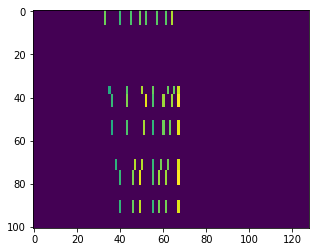

In [124]:
ex = corpus[0]['pr']

#ref https://www.tensorflow.org/tutorials/sequences/text_generation

seq_length = 100
examples_per_epoch = ex.shape[1]
pr_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(ex.T, tf.float32)) #"".T"は転置
pr_dataset.output_shapes

#for i in pr_dataset.take(5):
#  print(i.numpy())
#  print(i.numpy().shape)

sequences = pr_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(3):
  plt.imshow(item.numpy())

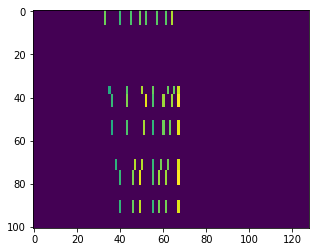

In [125]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

for item in sequences.take(3):
 plt.imshow(item.numpy())

In [126]:
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences, 
# so it doesn't attempt to shuffle the entire sequence in memory. Instead, 
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
#ref https://www.tensorflow.org/api_docs/python/tf/contrib/data/batch_and_drop_remainder

dataset

<BatchDataset shapes: ((64, 100, 128), (64, 100, 128)), types: (tf.float32, tf.float32)>

In [145]:
# The embedding dimension
embedding_dim = 256
# The number of notes in one column of piano roll.
keys_dim = 128
rnn_units = 1024

def build_model(batch_size, seq_length):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(
            embedding_dim,
            batch_input_shape=[batch_size, seq_length, keys_dim]),
        tf.keras.layers.GRU(
            rnn_units,
            recurrent_activation='sigmoid',
             return_sequences=True, 
             recurrent_initializer='glorot_uniform',
             stateful=True),
        tf.keras.layers.Dense(keys_dim),
    ])

model = build_model(BATCH_SIZE, seq_length)

#保存済みモデルがあったら読み込む。
model_path = "model.h5"
if os.path.exists(model_path):
    model.load_weights(model_path)
    
model.summary()

model.compile(loss="mean_squared_error", optimizer=tf.train.AdamOptimizer())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (64, 100, 256)            33024     
_________________________________________________________________
gru_6 (GRU)                  (64, 100, 1024)           3935232   
_________________________________________________________________
dense_13 (Dense)             (64, 100, 128)            131200    
Total params: 4,099,456
Trainable params: 4,099,456
Non-trainable params: 0
_________________________________________________________________


### Try the model

In [128]:
for input_example_batch, target_example_batch in dataset.take(1): 
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(TensorShape([Dimension(64), Dimension(100), Dimension(128)]), '# (batch_size, sequence_length, vocab_size)')


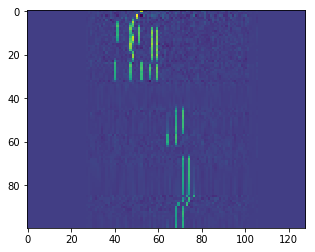

In [129]:
plt.imshow(example_batch_predictions.numpy()[0])

In [133]:
piano_roll_to_pretty_midi(example_batch_predictions.numpy()[0]).write("try-the-model.mid")

### Train the model

In [134]:
#  model.fit(dataset.repeat(), epochs=3, steps_per_epoch=steps_per_epoch)
# model.save("model.h5")

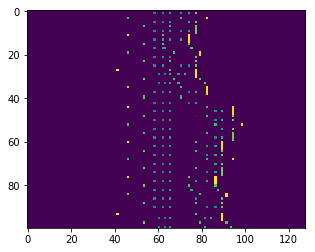

In [135]:
for input_example_batch, target_example_batch in dataset.take(1): 
    plt.imshow(target_example_batch.numpy()[0])
    piano_roll_to_pretty_midi(target_example_batch.numpy()[0].T).write("train-the-model-target.mid")
    example_batch_predictions_2 = model(input_example_batch)

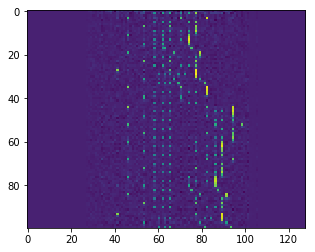

In [136]:
piano_roll_to_pretty_midi(example_batch_predictions_2.numpy()[0].T).write("train-the-model.mid")
plt.imshow(example_batch_predictions_2.numpy()[0])

In [137]:
print(np.where((np.diff(example_batch_predictions_2.numpy()[0].T).T)>10))

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  2,  2,  2,  2,
        4,  4,  4,  4,  4,  4,  6,  6,  6,  7,  8,  8,  8,  8,  8,  8, 10,
       10, 10, 10, 10, 11, 12, 12, 12, 12, 14, 14, 14, 16, 16, 16, 16, 18,
       18, 18, 18, 20, 20, 20, 20, 20, 20, 22, 22, 22, 24, 24, 24, 24, 24,
       26, 26, 26, 26, 26, 26, 28, 28, 28, 28, 28, 28, 30, 30, 30, 30, 31,
       32, 32, 32, 32, 32, 34, 34, 34, 34, 36, 36, 36, 36, 36, 38, 38, 38,
       38, 41, 41, 41, 41, 41, 43, 43, 43, 43, 43, 43, 45, 45, 45, 45, 45,
       45, 46, 47, 47, 47, 49, 49, 49, 49, 49, 49, 49, 51, 51, 51, 51, 51,
       52, 53, 53, 53, 53, 53, 55, 55, 55, 57, 57, 57, 57, 57, 57, 59, 59,
       59, 59, 59, 60, 61, 61, 61, 61, 61, 61, 63, 63, 63, 65, 65, 65, 65,
       65, 65, 67, 67, 67, 67, 69, 69, 69, 69, 69, 69, 71, 71, 71, 73, 73,
       73, 73, 73, 73, 73, 75, 75, 75, 75, 75, 75, 77, 77, 77, 77, 77, 79,
       79, 79, 79, 81, 81, 81, 81, 81, 83, 83, 83, 83, 83, 85, 85, 85, 85,
       85, 85, 87, 87, 8

In [138]:
# 学習して生成したpiano rollをmidi fileを元に戻す
import pretty_midi
def piano_roll_to_pretty_midi(piano_roll, fs=100.0, program=1):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.abs(np.diff(piano_roll).T)>10) # 要素間の差分をとる

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 20:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = np.clip(velocity, 0, 127)
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

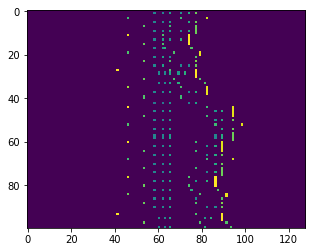

In [139]:
plt.imshow(piano_roll_to_pretty_midi(target_example_batch.numpy()[0].T).get_piano_roll().T)

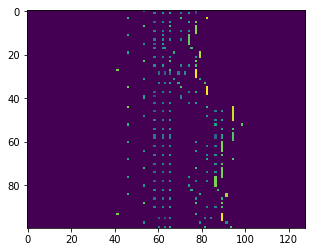

In [140]:
plt.imshow(piano_roll_to_pretty_midi(example_batch_predictions_2.numpy()[0].T).get_piano_roll().T)

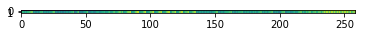

In [71]:
plt.imshow(np.nonzero(np.diff(target_example_batch.numpy()[0], axis = 0)))

### Generate Music

In [149]:
model = build_model(1, None)
model.load_weights(model_path)
model.build(tf.TensorShape([1, None, keys_dim]))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (1, None, 256)            33024     
_________________________________________________________________
gru_8 (GRU)                  (1, None, 1024)           3935232   
_________________________________________________________________
dense_17 (Dense)             (1, None, 128)            131200    
Total params: 4,099,456
Trainable params: 4,099,456
Non-trainable params: 0
_________________________________________________________________


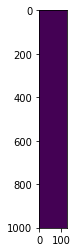

In [153]:
# Number of  notes to generate
num_generate = 1000

# Buffer for output
result = np.zeros([num_generate+1, keys_dim], dtype=np.float32)
plt.imshow(result)

In [154]:
# Make first inout
input_eval = tf.expand_dims(result[0:1], 0)
input_eval.shape

TensorShape([Dimension(1), Dimension(1), Dimension(128)])

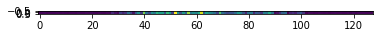

In [155]:
# Try to generate first
model.reset_states()
predictions = model(input_eval)
predictions = tf.squeeze(predictions, 0)
result[1] = predictions
plt.imshow(predictions)

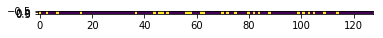

In [189]:
# Initialize first keys randomly
for i in range(10):
    key = int(np.clip(np.random.normal(keys_dim/2, keys_dim/4), 0, keys_dim - 1))
    result[0][key] = 100
    
plt.imshow(result[0:1])

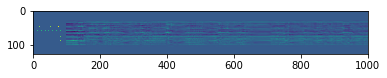

In [194]:
# Use training data
intro = target_example_batch[0]
intro_length = intro.shape[0]
result[0 : intro_length] = intro
plt.imshow(result.T)

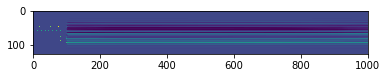

In [196]:
# Generate all
model.reset_states()
for i in range(num_generate):
    input_eval = tf.expand_dims(result[ i : i + 1], 0)
    predictions = model(input_eval)
    if i > intro_length - 2:
        result[ i + 1] = tf.squeeze(predictions, 0)

plt.imshow(result.T)

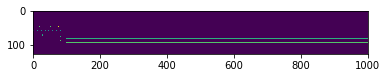

In [197]:
result_midi = piano_roll_to_pretty_midi(result.T)
result_midi.write("result.midi")
plt.imshow(result_midi.get_piano_roll())